In [10]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

In [7]:
def order_points(pts):
    # Order points: top-left, top-right, bottom-right, bottom-left
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect

def find_dest(corners):
    # Define the destination points for perspective transformation
    (tl, tr, br, bl) = corners
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    # Destination points for the transformation
    destination = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]
    ], dtype="float32")
    return destination


In [8]:
def scan(img):
    # Resize image to workable size
    dim_limit = 1080
    max_dim = max(img.shape)
    if max_dim > dim_limit:
        resize_scale = dim_limit / max_dim
        img = cv2.resize(img, None, fx=resize_scale, fy=resize_scale)

    # Create a copy of resized original image for later use
    orig_img = img.copy()

    # Repeated Closing operation to remove text from the document.
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel, iterations=3)

    # GrabCut
    mask = np.zeros(img.shape[:2], np.uint8)
    bgdModel = np.zeros((1, 65), np.float64)
    fgdModel = np.zeros((1, 65), np.float64)
    rect = (20, 20, img.shape[1] - 20, img.shape[0] - 20)
    cv2.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv2.GC_INIT_WITH_RECT)
    mask2 = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    img = img * mask2[:, :, np.newaxis]

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (11, 11), 0)

    # Edge Detection
    canny = cv2.Canny(gray, 0, 200)
    canny = cv2.dilate(canny, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5)))

    # Finding contours for the detected edges
    contours, hierarchy = cv2.findContours(canny, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)

    # Keeping only the largest detected contour
    page = sorted(contours, key=cv2.contourArea, reverse=True)[:5]

    # Detecting Edges through Contour approximation
    if len(page) == 0:
        return orig_img

    for c in page:
        # Approximate the contour
        epsilon = 0.02 * cv2.arcLength(c, True)
        corners = cv2.approxPolyDP(c, epsilon, True)

        # If our approximated contour has four points
        if len(corners) == 4:
            break

    # Ensure corners is a NumPy array
    corners = np.array(sorted(np.concatenate(corners).tolist()), dtype=np.float32)

    # Sort the corners and convert them to the desired shape
    corners = order_points(corners)

    destination_corners = find_dest(corners)

    # Getting the homography
    M = cv2.getPerspectiveTransform(np.float32(corners), np.float32(destination_corners))

    # Correctly extract width and height from destination_corners
    maxWidth = int(destination_corners[1][0])  # Width from top-right corner
    maxHeight = int(destination_corners[2][1])  # Height from bottom-right corner

    # Perspective transform using homography
    final = cv2.warpPerspective(orig_img, M, (maxWidth, maxHeight), flags=cv2.INTER_LINEAR)

    return final


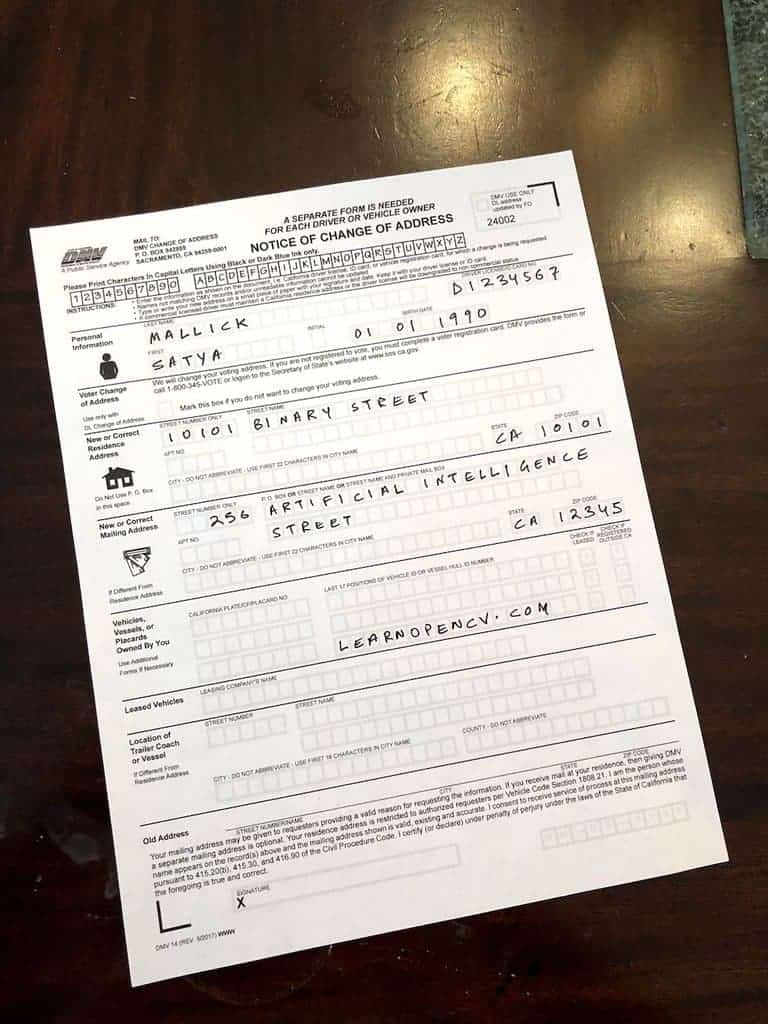

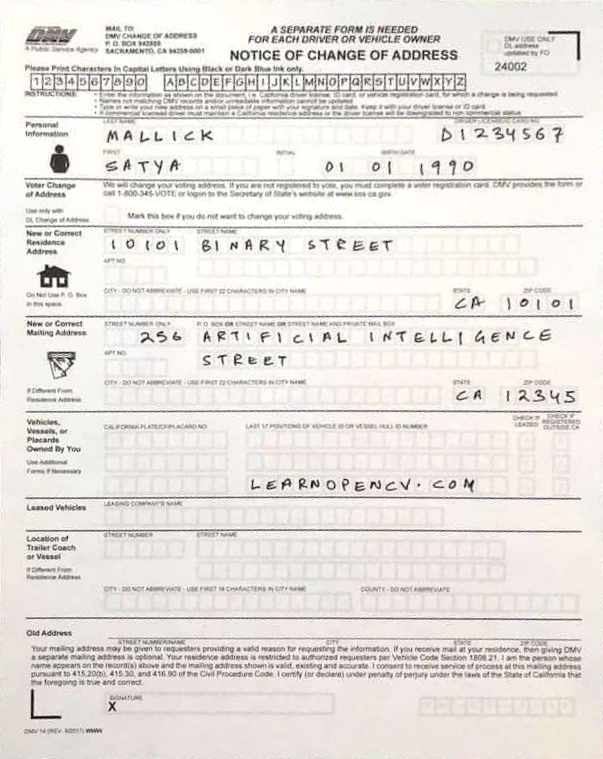

True

In [13]:
# Load the image
img = cv2.imread('/content/Originalimg.jpg')

# Call the scan function
scanned_img = scan(img)

# Display the results
cv2_imshow(img)
cv2_imshow(scanned_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally, save the scanned image
cv2.imwrite('scanned_document.jpg', scanned_img)